# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os

Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [3]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [4]:
# token expires every 30 min
COURSERA_TOKEN = 'W2o4XjKHf6NeaYQp'### YOUR TOKEN HERE
COURSERA_EMAIL = 'whisper4738@gmail.com'### YOUR EMAIL HERE

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [ ]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [5]:
IMG_SIZE = 299

In [6]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(0)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.engine.training.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
K.clear_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [7]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [8]:
train_img_fns[:5]

['COCO_train2014_000000270070.jpg',
 'COCO_train2014_000000101772.jpg',
 'COCO_train2014_000000359320.jpg',
 'COCO_train2014_000000486482.jpg',
 'COCO_train2014_000000116155.jpg']

In [9]:
len(set(train_img_fns))

82783

In [10]:
train_img_embeds[0]

array([0.13804615, 0.05108397, 0.22299135, ..., 0.03206269, 0.00304687,
       0.52839714], dtype=float32)

In [10]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

In [11]:
os.listdir(".")

['.ipynb_checkpoints',
 'captions_train-val2014.zip',
 'grading_utils.py',
 'images',
 'train2014_sample.zip',
 'train_img_embeds.pickle',
 'train_img_fns.pickle',
 'utils.py',
 'val2014_sample.zip',
 'val_img_embeds.pickle',
 'val_img_fns.pickle',
 'week6_final_project_image_captioning_clean-Copy1.ipynb',
 'week6_final_project_image_captioning_clean.ipynb',
 '__pycache__']

In [12]:
os.listdir('..')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'download_resources.ipynb',
 'download_utils.py',
 'grading.py',
 'keras_utils.py',
 'README.md',
 'readonly',
 'week1',
 'week2',
 'week3',
 'week4',
 'week5',
 'week6',
 '__pycache__']

In [13]:
for path,d,filelist in os.walk(".."):
    for filename in filelist:
        print(os.path.join(path,filename))

..\.gitignore
..\download_resources.ipynb
..\download_utils.py
..\grading.py
..\keras_utils.py
..\README.md
..\.git\config
..\.git\description
..\.git\HEAD
..\.git\index
..\.git\packed-refs
..\.git\hooks\applypatch-msg.sample
..\.git\hooks\commit-msg.sample
..\.git\hooks\fsmonitor-watchman.sample
..\.git\hooks\post-update.sample
..\.git\hooks\pre-applypatch.sample
..\.git\hooks\pre-commit.sample
..\.git\hooks\pre-push.sample
..\.git\hooks\pre-rebase.sample
..\.git\hooks\pre-receive.sample
..\.git\hooks\prepare-commit-msg.sample
..\.git\hooks\update.sample
..\.git\info\exclude
..\.git\logs\HEAD
..\.git\logs\refs\heads\master
..\.git\logs\refs\remotes\origin\HEAD
..\.git\objects\pack\pack-2d23a1053422e5913c03a36711b39174113402a9.idx
..\.git\objects\pack\pack-2d23a1053422e5913c03a36711b39174113402a9.pack
..\.git\refs\heads\master
..\.git\refs\remotes\origin\HEAD
..\.ipynb_checkpoints\download_resources-checkpoint.ipynb
..\readonly\keras\models\inception_v3_weights_tf_dim_ordering_tf_kerne

# Extract captions for images

In [8]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


In [15]:
train_captions[0]

['A long dirt road going through a forest.',
 'A SCENE OF WATER AND A PATH WAY',
 'A sandy path surrounded by trees leads to a beach.',
 'Ocean view through a dirt road surrounded by a forested area. ',
 'dirt path leading beneath barren trees to open plains']

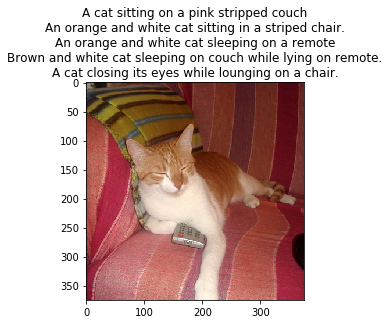

In [9]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

In [17]:
zf = zipfile.ZipFile("train2014_sample.zip")
zf.filelist[:5]

[<ZipInfo filename='train2014/COCO_train2014_000000092353.jpg' filemode='-rw-rw-r--' file_size=167514>,
 <ZipInfo filename='train2014/COCO_train2014_000000148908.jpg' filemode='-rw-rw-r--' file_size=194378>,
 <ZipInfo filename='train2014/COCO_train2014_000000558467.jpg' filemode='-rw-rw-r--' file_size=199372>,
 <ZipInfo filename='train2014/COCO_train2014_000000474720.jpg' filemode='-rw-rw-r--' file_size=172997>,
 <ZipInfo filename='train2014/COCO_train2014_000000352107.jpg' filemode='-rw-rw-r--' file_size=113544>]

In [18]:
zf.filelist[0].filename.rsplit("/")[-1]

'COCO_train2014_000000092353.jpg'

In [19]:
zf.read(zf.filelist[0])

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe1\x0b\x0eXMP\x00://ns.adobe.com/xap/1.0/\x00<?xpacket begin=\'\xef\xbb\xbf\' id=\'W5M0MpCehiHzreSzNTczkc9d\'?>\n<x:xmpmeta xmlns:x=\'adobe:ns:meta/\' x:xmptk=\'Image::ExifTool 6.54\'>\n<rdf:RDF xmlns:rdf=\'http://www.w3.org/1999/02/22-rdf-syntax-ns#\'>\n\n <rdf:Description rdf:about=\'\'\n  xmlns:xmp=\'http://ns.adobe.com/xap/1.0/\'>\n  <xmp:CreatorTool>picnik.com</xmp:CreatorTool>\n </rdf:Description>\n</rdf:RDF>\n</x:xmpmeta>\n                                                                                                    \n                                                                                                    \n                                                                                                    \n                                                                                                    \n                                                                                        

# Prepare captions for training

In [20]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [10]:
from collections import Counter
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    word_counts = Counter()
    for train_caption in train_captions:
        for word in map(split_sentence, train_caption):
            word_counts.update(word)
    vocab = list(filter(lambda x: word_counts[x] >= 5, word_counts))
    for i in [PAD, UNK, START, END]:
        vocab.append(i)
    return {token: int(index) for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = []
    for caption in captions:
        res_caption = []
        for words in map(split_sentence, caption):
            setence = [vocab[START]]
            for word in words:
                if word in vocab:
                    setence.append(vocab[word])
                else:
                    setence.append(vocab[UNK])
            setence.append(vocab[END])
            res_caption.append(setence)
        res.append(res_caption)
    #res = ### YOUR CODE HERE ###
    return res

In [22]:
from collections import Counter
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))
word_counts = Counter()
for train_caption in train_captions[:1]:
    for word in map(split_sentence, train_caption):
        word_counts.update(word)
        print(word)
#print(word_counts)
wo = list(filter(lambda x: word_counts[x] >= 5, word_counts))
wo.append(PAD)

['a', 'long', 'dirt', 'road', 'going', 'through', 'a', 'forest']
['a', 'scene', 'of', 'water', 'and', 'a', 'path', 'way']
['a', 'sandy', 'path', 'surrounded', 'by', 'trees', 'leads', 'to', 'a', 'beach']
['ocean', 'view', 'through', 'a', 'dirt', 'road', 'surrounded', 'by', 'a', 'forested', 'area']
['dirt', 'path', 'leading', 'beneath', 'barren', 'trees', 'to', 'open', 'plains']


In [11]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [29]:
vocab[PAD]

1

In [12]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [26]:
train_captions[0]

['A long dirt road going through a forest.',
 'A SCENE OF WATER AND A PATH WAY',
 'A sandy path surrounded by trees leads to a beach.',
 'Ocean view through a dirt road surrounded by a forested area. ',
 'dirt path leading beneath barren trees to open plains']

In [27]:
train_captions_indexed[0]

[[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0],
 [2, 54, 6540, 5127, 8486, 249, 54, 5437, 8507, 0],
 [2, 54, 6502, 5437, 7581, 1124, 8052, 4287, 7905, 54, 639, 0],
 [2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0],
 [2, 2305, 5437, 4286, 710, 587, 8052, 7905, 5174, 5684, 0]]

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an euqal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [14]:
grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK)

[1, 1, 8766, 8768, 1, 23303]

In [13]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    max_len = max_len or max(map(len,batch_captions))
    max_len = min(max_len, max(map(len,batch_captions)))
    matrix = np.empty([len(batch_captions),max_len],dtype='int32')
    matrix.fill(pad_idx)
    
    for i in range(len(batch_captions)):
        line_ix = batch_captions[i][:max_len]
        matrix[i,:len(line_ix)] = line_ix
    
    #matrix = ###YOUR CODE HERE###
    return matrix

In [18]:
batch_captions = [[1, 2, 3], [4, 5]]
matrix = np.empty([len(batch_captions),10],dtype='int32')
matrix.fill(-1)
matrix

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [16]:
for i in range(len(batch_captions)):
    line_ix = batch_captions[i][:10]
    matrix[i,:len(line_ix)] = line_ix
matrix

NameError: name 'batch_captions' is not defined

In [14]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [42]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [15]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [16]:
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

In [17]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits` layer
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, tf.ones_like(flat_ground_truth)*pad_idx)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    xent_mask = tf.boolean_mask(xent, flat_loss_mask)
    loss = tf.reduce_sum(xent_mask)### YOUR CODE HERE ###
    loss /= tf.reduce_sum(tf.cast(flat_loss_mask, 'float32'))
    #loss /= tf.cast(tf.shape(img_embeds)[0], 'float32')

In [18]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [19]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [62]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [20]:
def get_fd(decoder):
    batch = 10
    batch_sl = 5
    return {
        decoder.img_embeds: np.random.random((batch, IMG_EMBED_SIZE)),
        decoder.sentences: np.random.randint(0, len(vocab), (batch, batch_sl))
    }

res = s.run(decoder.flat_ground_truth, feed_dict=get_fd(decoder))
print('loss', res)

loss [5927 1847 2068 1869 5620 5419 1012 5865 4219 7324 6872   13 2428 3112
 2341 1954 5160 2679 4872 4201 5144 3931  761 4350 8416 3218 7390 8180
 6181 8308 7833 4361 5059 1414  811 6679  778  866 2064 5059]


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [21]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [22]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    selected = np.random.choice(len(images_embeddings), batch_size)
    batch_image_embeddings = images_embeddings[selected]### YOUR CODE HERE ###
    
    selected_captions = list([cap[np.random.choice(len(cap))] for cap in indexed_captions[selected]])
    batch_captions_matrix = batch_captions_to_matrix(selected_captions, pad_idx=1, max_len = max_len)### YOUR CODE HERE ###
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [25]:
batch_size = 64
n_epochs = 25
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [24]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
saver.restore(s, os.path.abspath("weights"))

INFO:tensorflow:Restoring parameters from D:\intro-to-dl\week6\weights


DataLossError: Checksum does not match: stored 794682855 vs. calculated on the restored bytes 3071509568
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
	 [[Node: save/RestoreV2/_75 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_12_save/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save/RestoreV2', defined at:
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-2a15ffc848ce>", line 7, in <module>
    saver = tf.train.Saver()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1284, in __init__
    self.build()
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 400, in _AddRestoreOps
    restore_sequentially)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 832, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1546, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

DataLossError (see above for traceback): Checksum does not match: stored 794682855 vs. calculated on the restored bytes 3071509568
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
	 [[Node: save/RestoreV2/_75 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_12_save/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


Look at the training and validation loss, they should be decreasing!

In [26]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")


Epoch: 0, train loss: 4.244506975650787, val loss: 3.6476773738861086



Epoch: 1, train loss: 3.300372068166733, val loss: 3.128921537399292



Epoch: 2, train loss: 2.9759165735244753, val loss: 2.897258415222168



Epoch: 3, train loss: 2.8359655628204345, val loss: 2.8235622310638426



Epoch: 4, train loss: 2.753454537153244, val loss: 2.7976923251152037



Epoch: 5, train loss: 2.6733556373119356, val loss: 2.741882405281067



Epoch: 6, train loss: 2.632113941192627, val loss: 2.698984582424164



Epoch: 7, train loss: 2.589434398174286, val loss: 2.6415840077400206



Epoch: 8, train loss: 2.5620684547424317, val loss: 2.622581653594971



Epoch: 9, train loss: 2.525131665468216, val loss: 2.592385151386261



Epoch: 10, train loss: 2.499725342988968, val loss: 2.5914193987846375



Epoch: 11, train loss: 2.480793685436249, val loss: 2.5859415221214292



Epoch: 12, train loss: 2.456849021196365, val loss: 2.583398013114929



Epoch: 13, train loss: 2.437781744003296, val loss: 2.5514326739311217



Epoch: 14, train loss: 2.432497375488281, val loss: 2.547718698978424



Epoch: 15, train loss: 2.408815385103226, val loss: 2.558173270225525



Epoch: 16, train loss: 2.400652135848999, val loss: 2.542133424282074



Epoch: 17, train loss: 2.3857310360670088, val loss: 2.537266263961792



Epoch: 18, train loss: 2.3773676899671554, val loss: 2.5491100764274597



Epoch: 19, train loss: 2.359277318120003, val loss: 2.514921536445618



Epoch: 20, train loss: 2.3526532270908356, val loss: 2.5214773082733153



Epoch: 21, train loss: 2.340543581843376, val loss: 2.4907286548614502



Epoch: 22, train loss: 2.3328923451900483, val loss: 2.500376813411713



Epoch: 23, train loss: 2.3269581265449526, val loss: 2.4936926341056824



Epoch: 24, train loss: 2.3173987164497376, val loss: 2.497096989154816
Finished!


In [31]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

In [52]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [27]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.1114526
Accuracy: 0.5134048257372654
Example 0
Predicted: a man holding a hot of with food and #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man holding a box filled with green salad #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man child playing playing in front living with #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a small child is standing in a room #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a living with with furniture and a tv place #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a room filled with furniture and a fire place #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [28]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

'D:\\intro-to-dl\\week6\\weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [29]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm.call(inputs = word_embed, state = tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from D:\intro-to-dl\week6\weights


In [30]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [31]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a baseball player swinging a bat at a ball


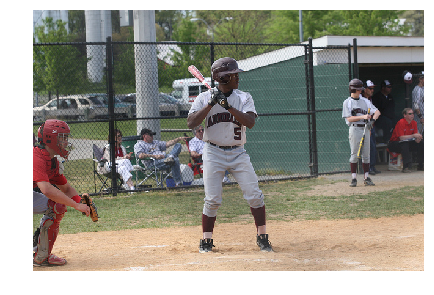

In [32]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a room with a desk and a chair and a computer


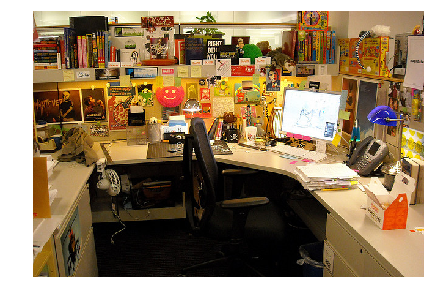

a woman in a suit and tie is holding a cell phone


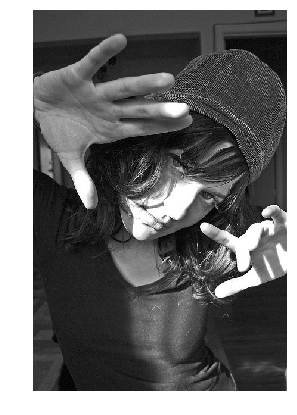

a cat is sitting on a laptop computer


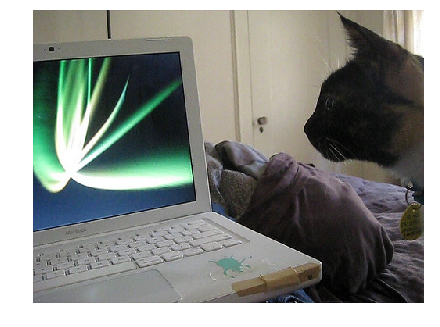

a bear is sitting on a rock in a zoo


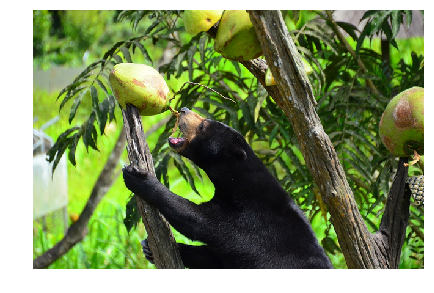

a young girl holding a baby in a room


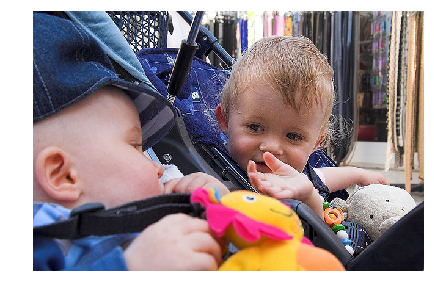

a woman holding a tennis racquet on a tennis court


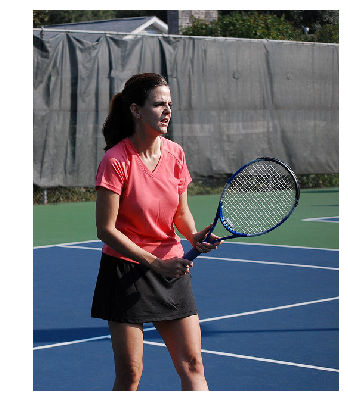

a kitchen with a microwave and a microwave


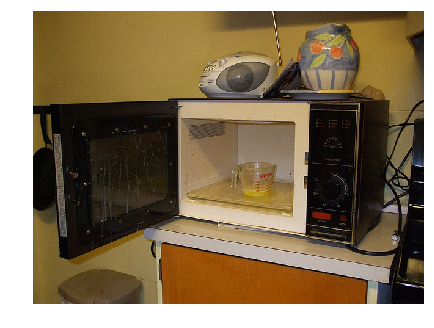

a bear is standing in the grass with a tree in the background


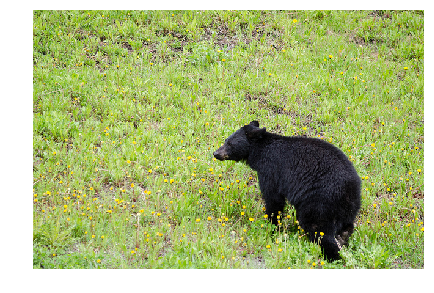

a man sitting at a table with a pizza


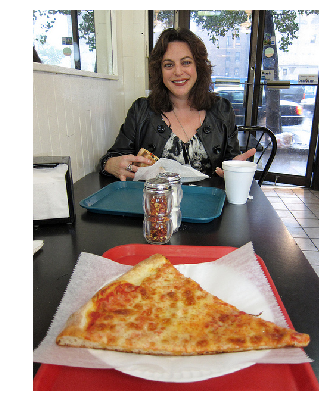

a laptop computer sitting on top of a desk


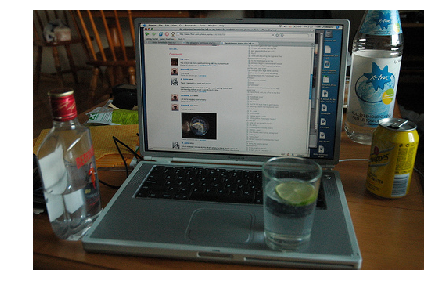

In [33]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [34]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

C:\Users\minori\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a cake with a frosting and sprinkles on it


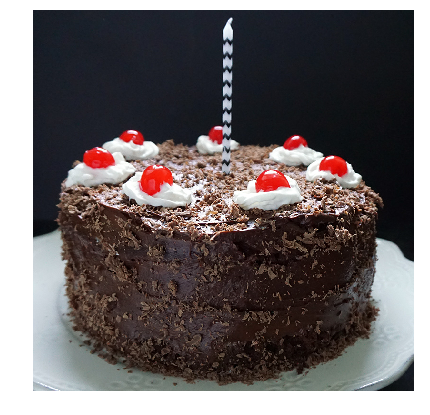

In [35]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

In [ ]:
### YOUR EXAMPLES HERE ###

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!